In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def t2f(x: torch.Tensor) -> np.ndarray:
    return x.detach().cpu().numpy().flatten()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


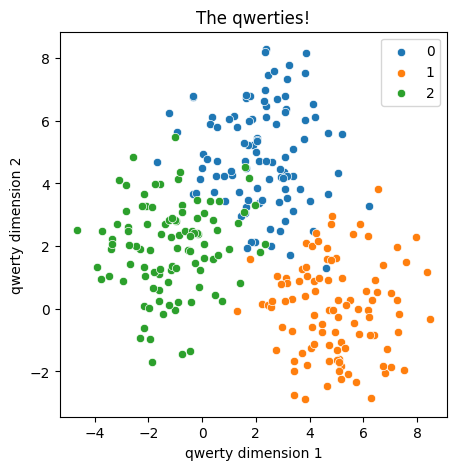

In [8]:
# create data

n_per_clust = 100
blur = 1.5

A = [2, 5]
B = [5, 0]
C = [-1, 2]

# generate data
a = [
    A[0] + np.random.randn(n_per_clust) * blur,
    A[1] + np.random.randn(n_per_clust) * blur,
]
b = [
    B[0] + np.random.randn(n_per_clust) * blur,
    B[1] + np.random.randn(n_per_clust) * blur,
]
c = [
    C[0] + np.random.randn(n_per_clust) * blur,
    C[1] + np.random.randn(n_per_clust) * blur,
]

# true labels
labels_np = np.hstack(
    (np.zeros(n_per_clust), np.ones(n_per_clust), 2 * np.ones(n_per_clust))
)

# concatanate into a matrix
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np, device=device).float()
labels = torch.tensor(labels_np, device=device).type(torch.long).reshape(-1)

# show the data
plt.figure(figsize=(5, 5))
sns.scatterplot(x=data_np[labels_np == 0, 0], y=data_np[labels_np == 0, 1], label='0')
sns.scatterplot(x=data_np[labels_np == 1, 0], y=data_np[labels_np == 1, 1], label='1')
sns.scatterplot(x=data_np[labels_np == 2, 0], y=data_np[labels_np == 2, 1], label='2')
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()


In [3]:
ANNclassify = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 4),
    nn.ReLU(),
    nn.Linear(4, 3),
).to(device)
learning_rate = 0.1
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learning_rate)


In [11]:
type(lossfun)

torch.nn.modules.loss.CrossEntropyLoss

In [4]:
numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs, device=device)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

    # forward pass
    yHat = ANNclassify(data)

    # compute loss
    loss = lossfun(yHat, labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute accuracy
    matches = torch.argmax(yHat, axis=1) == labels  # booleans (false/true)
    matchesNumeric = matches.float()  # convert to numbers (0/1)
    accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100
    ongoingAcc.append(accuracyPct)  # add to list of accuracies


# final forward pass
predictions = ANNclassify(data)

predlabels = torch.argmax(predictions, axis=1)
totalacc = 100 * torch.mean((predlabels == labels).float())


Final accuracy: 94.66667175292969%


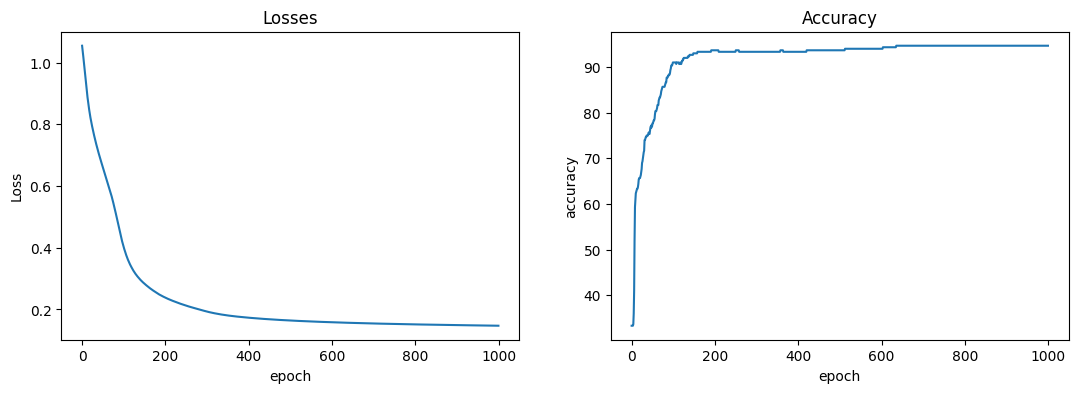

In [5]:
# report accuracy
print(f'Final accuracy: {totalacc}%')

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(t2f(losses))
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(list(map(t2f,ongoingAcc)))
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()
# run training again to see whether this performance is consistent

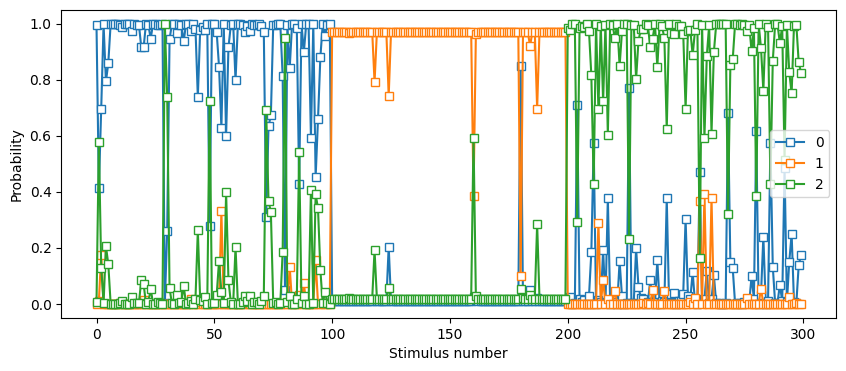

In [10]:
fig = plt.figure(figsize=(10,4))
sm = nn.Softmax(1)
plt.plot(sm(yHat).detach().cpu(),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['0','1','2'])
plt.show()